## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [2]:
print(df.index.is_monotonic)

True


# 2. Анализ

In [5]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


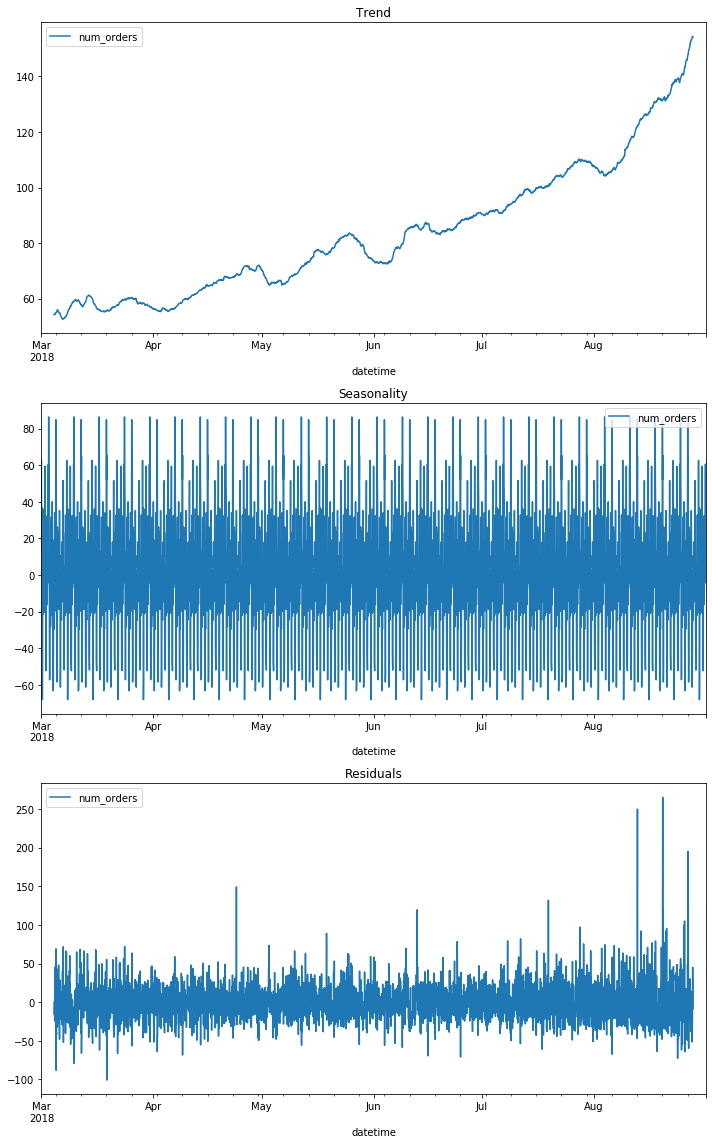

In [6]:
decomposed = seasonal_decompose(df, freq=24*7)

plt.figure(figsize=(10, 16))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

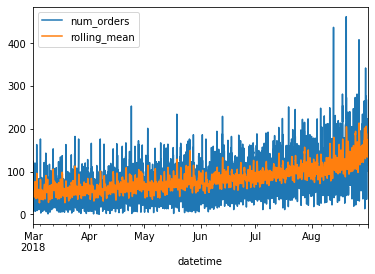

In [7]:
df['rolling_mean'] = df.rolling(10).mean()
df.plot()

Спрос на такси ощутимо растёт. На графике тренда даже немного похоже на график экспоненты. Стохастический процесс нестационарный.

# 3. Обучение и анализ

In [8]:
%%time

from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

result = pd.DataFrame(columns = ['max_lag', 'rolling_mean_size', 'rmse_valid_Lasso', 'rmse_valid_Ridge'])
i= 0

for max_lag in range(1, 100, 5):
    for rolling_mean_size in range(1, 100, 5):

        make_features(df, max_lag, rolling_mean_size)

        other, test = train_test_split(df, shuffle=False, test_size=0.1)
        train, valid = train_test_split(other, shuffle=False, test_size=0.25)
        train = train.dropna()

        f_train = train.drop('num_orders', axis=1)
        t_train = train['num_orders']
        f_valid = valid.drop('num_orders', axis=1)
        t_valid = valid['num_orders']
        f_test = test.drop('num_orders', axis=1)
        t_test = test['num_orders']
        
        model1 = linear_model.Lasso(alpha=0.1).fit(f_train, t_train)
        valid_pred1 = model1.predict(f_valid)
        rmse_valid1 = mean_squared_error(t_valid,valid_pred1 ) ** .5
        
        model2 = Ridge(alpha=0.1).fit(f_train, t_train)
        valid_pred2 = model2.predict(f_valid)
        rmse_valid2 = mean_squared_error(t_valid,valid_pred2 ) ** .5
        
        result.loc[i, 'max_lag'] = max_lag
        result.loc[i, 'rolling_mean_size'] = rolling_mean_size
        result.loc[i, 'rmse_valid_Lasso'] = rmse_valid1
        result.loc[i, 'rmse_valid_Ridge'] = rmse_valid2
        i +=1
        
result.sort_values('rmse_valid_Lasso', ascending = True)   

CPU times: user 2min 36s, sys: 4min 6s, total: 6min 43s
Wall time: 6min 43s


,max_lag,rolling_mean_size,rmse_valid_Lasso,rmse_valid_Ridge
388,96,41,28.6696,28.7221
394,96,71,28.6696,28.7221
389,96,46,28.6696,28.7221
397,96,86,28.6696,28.7221
399,96,96,28.6696,28.7221
...,...,...,...,...
38,6,91,37.8884,37.9534
13,1,66,37.9497,37.9821
9,1,46,37.9664,37.9727
8,1,41,38.0068,38.0032


In [9]:
result.sort_values('rmse_valid_Ridge', ascending = True)

,max_lag,rolling_mean_size,rmse_valid_Lasso,rmse_valid_Ridge
383,96,16,28.672,28.7221
385,96,26,28.6731,28.7221
382,96,11,28.6723,28.7221
384,96,21,28.6723,28.7221
386,96,31,28.6733,28.7221
...,...,...,...,...
38,6,91,37.8884,37.9534
9,1,46,37.9664,37.9727
13,1,66,37.9497,37.9821
8,1,41,38.0068,38.0032


In [10]:
make_features(df, 96, 41)

other, test = train_test_split(df, shuffle=False, test_size=0.1)
train, valid = train_test_split(other, shuffle=False, test_size=0.25)
train = train.dropna()

f_train = train.drop('num_orders', axis=1)
t_train = train['num_orders']
f_valid = valid.drop('num_orders', axis=1)
t_valid = valid['num_orders']
f_test = test.drop('num_orders', axis=1)
t_test = test['num_orders']
        
test_pred1 = model1.predict(f_test)
rmse_test1 = mean_squared_error(t_test,test_pred1 ) ** .5
rmse_test1

44.01170698722157

Путём перебора добились rmse= 44, что меньше порогового 48.